<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SPT" data-toc-modified-id="SPT-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SPT</a></span></li><li><span><a href="#VQE" data-toc-modified-id="VQE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VQE</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test</a></span></li></ul></div>

# SPT
In the paper they consider the infinite one dimensional spin-$\frac{1}{2}$ chains, described by three parameters:
$$
H = \sum_i \big[ -g_{zz} \sigma^z_i \sigma_{i+1}^z - g_x \sigma_i^x + g_{zxz}\sigma_i^z \sigma_{i+1}^x \sigma_{i+1}^z\big]
$$

This hamiltonian is symmetric under global spin flips generated by $\prod_i \sigma_i^x$. They focus on the following path:

$g_{zz} = 2(1 - g^2)$, $g_x = (1 + g)^2$, $g_{zxz}=(g-1)^2$ with tunable parameter $g$, varying g from -1 to 1.

The string order parameters that are used are of the form:

$$
S^O(g) = \langle \psi | O_i \bigg(\prod_{j=i+2}^{k-2} \sigma_j^x \bigg) O'_k | \psi \rangle
$$

With $O_i = \sigma_i^z \sigma_{i+1}^y$ and $O'_k = \sigma_{k-1}^y \sigma_k^z$ defining $S^{YZ}(g)$ and $O_i = O'_k = 1$ defining $S^1$. 

Along the path chosen we have that those string order parameters have the following behaviour:
- $S^{YZ}(g)$ is zero for $g > 0$ and equal to $\frac{4 |g|}{(1 + |g|)^2}$ for $g< 0$;
- $S^{1}(g)$ is zero for $g < 0$ and equal to $\frac{4 |g|}{(1 + |g|)^2}$ for $g> 0$;

In [15]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit.aqua.operators import I, X, Y, Z
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA

# VOLTA
from VOLTA.VQD import VQD
from VOLTA.utils import classical_solver
from VOLTA.Hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def SPT_hamiltonian(g:float):
    gzz = 2*(1 - g**2)
    gx = (1 + g)**2
    gzxz = (g - 1)**2
    return - (gzz*(Z^Z^I^I^I) + gzz*(I^Z^Z^I^I) + gzz*(I^I^Z^Z^I) + gzz*(I^I^I^Z^Z)) - (gx*(X^I^I^I^I) + gx*(I^X^I^I^I) + gx*(I^I^X^I^I) + gx*(I^I^I^X^I) + gx*(I^I^I^I^X)) + (gzxz*(Z^X^Z^I^I) + gzxz*(I^Z^X^Z^I) + gzxz*(I^I^Z^X^Z))

In [55]:
g = 1
hamiltonian = SPT_hamiltonian(g)
print(hamiltonian)

SummedOp([
  -0.0 * ZZIII,
  -0.0 * IZZII,
  -0.0 * IIZZI,
  -0.0 * IIIZZ,
  -4.0 * XIIII,
  -4.0 * IXIII,
  -4.0 * IIXII,
  -4.0 * IIIXI,
  -4.0 * IIIIX,
  0.0 * ZXZII,
  0.0 * IZXZI,
  0.0 * IIZXZ
])


In [56]:
eigenvalues, _ = classical_solver(hamiltonian)
print(f"Energy Density: {eigenvalues[0]/3}")
print(f"Expected Energy: {-2*(1 + g**2)}")

Energy Density: -6.666666666666669
Expected Energy: -4


In [65]:
energy = []
n_points = 10
x = np.linspace(-1, 1, n_points)
for g in x:
    hamiltonian = SPT_hamiltonian(g)
    eigenvalues, _ = classical_solver(hamiltonian)
    energy.append(eigenvalues[0])

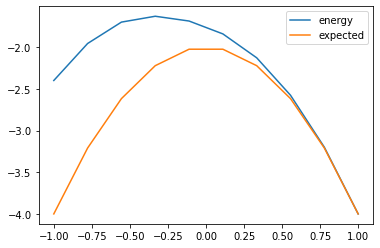

In [67]:
plt.plot(x, np.array(energy)/5, label='energy')
ideal = lambda g:-2*(1 + g**2)
plt.plot(x, ideal(x), label='expected')
plt.legend()
plt.show()

# VQE

In [16]:
import numpy as np
from VOLTA.Observables import sample_hamiltonian
from tqdm import tqdm
optimizer = COBYLA()
backend = BasicAer.get_backend('qasm_simulator')

def simulation(n_points:int,
              backend,
              optimizer) -> (np.array, np.array):
        g = np.linspace(-1, 1, n_points)
        result = []
        for g_val in tqdm(g):
            hamiltonian = SPT_hamiltonian(g_val)
            Algo = VQD(hamiltonian=hamiltonian,
                        n_excited_states=0,
                        beta=0.,
                        optimizer=optimizer,
                        backend=backend)
            Algo.run(0)      
            vqd_energies = Algo.energies
            vqd_states = Algo.states
            
            string_order = Z^Y^X^Y^Z
            res = sample_hamiltonian(hamiltonian=string_order,
                   backend=backend,
                   ansatz=vqd_states[0])
            result.append(res)
            
        return g, np.array(result)

100%|██████████| 10/10 [22:52<00:00, 135.22s/it]


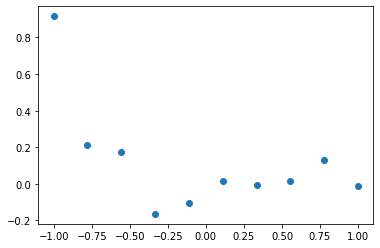

In [17]:
g, result = simulation(n_points=10,
                       backend=backend,
                       optimizer=optimizer)
plt.plot(g, result, 'o');

# Test

In [7]:
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import TwoLocal

optimizer = COBYLA(maxiter=10000)
backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                              shots=10000)

# Define ansatz
ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=2)

# Run algorithm
Algo = VQD(hamiltonian=hamiltonian,
            ansatz=ansatz,
            n_excited_states=0,
            beta=0.,
            optimizer=optimizer,
            backend=backend)

Algo.run(0)      
vqd_energies = Algo.energies
vqd_states = Algo.states
print(f'Energy: {vqd_energies[0]}')

Energy: -19.883200000000002


In [12]:
from VOLTA.Observables import sample_hamiltonian
#string_order = Z^Y^X^Y^Z
string_order = I^I^X^I^I
sample_hamiltonian(hamiltonian=string_order,
                   backend=backend,
                   ansatz=vqd_states[0])

0.9922000000000003

In [13]:
4*np.abs(g)/(1 + np.abs(g))**2

1.0